# 🎨 Supervised Classification
In this tutorial, it is required to identify between different hand-drawn shapes; such as rectangles, circles, triangles. This is considered to be classification over unstructured data (as opposed to structured data such as dataframes) <br><br>
<img src="https://i.imgur.com/b4KVZ61.png" width=800/>

In [4]:
import cv2
import numpy as np
import glob

Note of Caution: Ideally, your code should not define functions in notebooks (but rather in .py files) and should have type hints. This notebook was built for academic purposes.

## 1) Data Preparation

#### Prepare `x_data` and `y_data` for our model

In [5]:
## 1. Fill x_data and y_data:
x_data = []
y_data = []
shapes = [ 'circle', 'triangle', 'rectangle'] 

for shape in shapes:
    for filename in sorted(glob.glob(f'dataset/{shape}/*.png')):
        img = cv2.imread(filename, cv2.COLOR_BGR2RGB)       ## cv2.imread reads images in BGR format
        img = cv2.resize(img, (200, 200))                   ## resize the image to 200x200
        x_data.append(img)                                  ## add the image to x_data
        y_data.append(shapes.index(shape))                  ## add 0 or 1 or 2 to y_data as the label
        
# 2. Convert them to Numpy arrays:
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

# 3. Shuffle to avoid any bias:
p = np.random.permutation(len(x_data))
x_data = x_data[p]
y_data = y_data[p]

print("shape of x_data:", x_data.shape, "shape of y_data:", y_data.shape)

shape of x_data: (29, 200, 200, 3) shape of y_data: (29,)


#### Split into Train and Test

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=22, stratify=y_data)
print("shape of x_train:", x_train.shape, "shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape, "shape of y_test:", y_val.shape)

shape of x_train: (20, 200, 200, 3) shape of y_train: (20,)
shape of x_val: (9, 200, 200, 3) shape of y_test: (9,)


#### Plot the Dataset

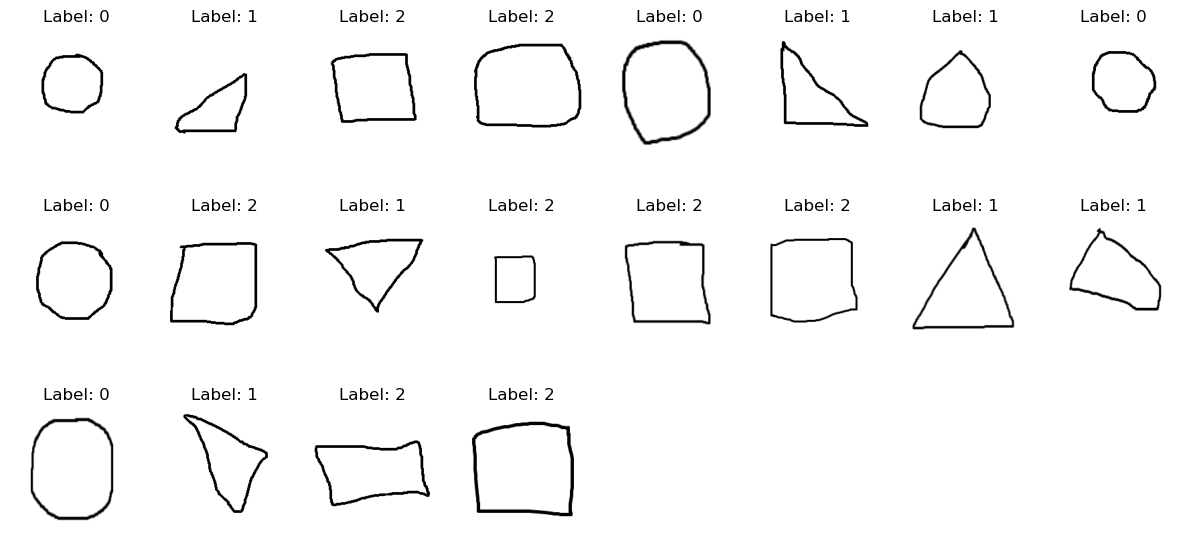

In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_dataset(x_data, y_data, num_cols=8, cmap=None):
    # Create a figure and axis objects
    num_images = len(y_data)
    fig, axes = plt.subplots(math.ceil(num_images / num_cols), num_cols, figsize=(12, 6))

    # Flatten the axes array to loop over them easily
    axes = axes.flatten()

    # Loop through the images and plot them
    for i in range(num_images):
        axes[i].imshow(x_data[i], cmap=cmap)
        axes[i].axis('off')
        axes[i].set_title('x_data Image')
        label = y_data[i]  
        axes[i].set_title('Label: {}'.format(label))
        
    # remove extra plots
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

plot_dataset(x_train, y_train, num_cols=8)

## 2) Data Preprocessing

There a few things to consider before we extract any features:
1. It's pointless to have three channels as each image is black and white
2. There may be noise in some of the images and blurring should help for that
3. It's pointless to have 255 colors for each pixels (0 or 1 is enough)

In [8]:
def preprocess_img(img):
    # Preprocess the given image img.
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.blur(gray_img, (3,3))        
    # pixels < 90 will be considered 0, and 255 otherwise.
    _, thresholded_img = cv2.threshold(blur_img, 90, 255, cv2.THRESH_BINARY)
    return thresholded_img

x_train_p = np.array([preprocess_img(img) for img in x_train])
x_val_p = np.array([preprocess_img(img) for img in x_val])

print("shape of x_train:", x_train_p.shape)
print("shape of x_val:", x_val_p.shape)

shape of x_train: (20, 200, 200)
shape of x_val: (9, 200, 200)


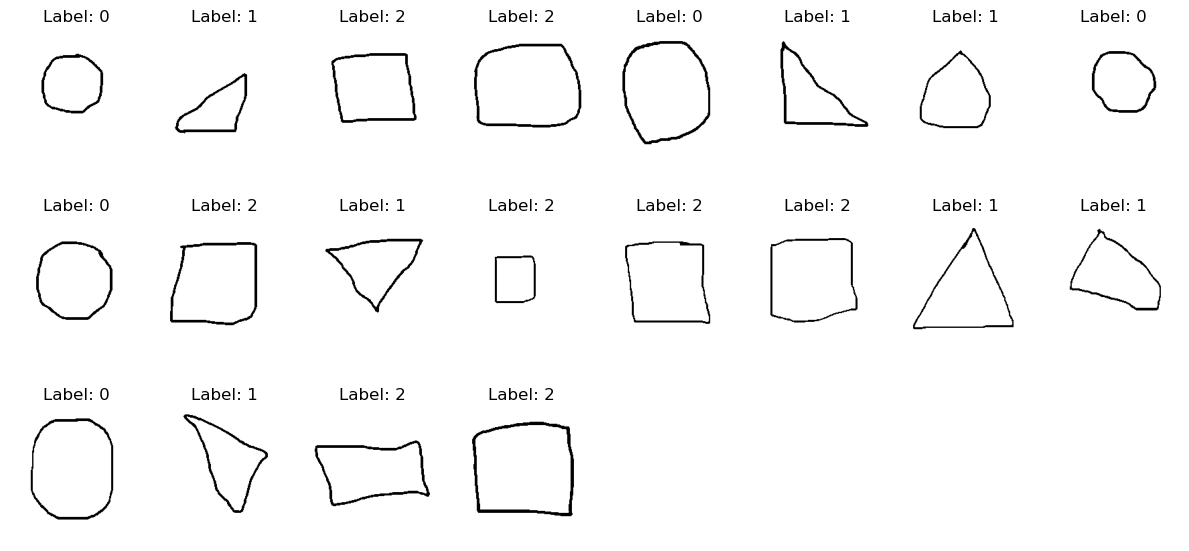

In [9]:
plot_dataset(x_train_p, y_train, num_cols=8, cmap='gray')

## 3) Feature Extraction

**This step could be either:**
    
- **Feature Engineering:** transformation of raw data into features suitable for modeling. (using domain knowledge to extract features)

- **Feature Transformation:** (transforming the whole feature space into a more meaningful one like in PCA or just applying a function on data concerning a certain feature)

- **Feature Selection:** removing unnecessary features.

Let's consider the most naive approach

In [10]:
def flatten_data(x_data):
    # Flatten the image data
    return x_data.reshape(x_data.shape[0], -1)

In [11]:
x_train_pf = flatten_data(x_train_p)
x_val_pf = flatten_data(x_val_p)
print("shape of x_train:", x_train_pf.shape)
print("shape of x_val:", x_val_pf.shape)

shape of x_train: (20, 40000)
shape of x_val: (9, 40000)


## 4) Model Selection

Let's start by trying [NearestCentroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html)

In [14]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

# initiate and train the model
mdc = NearestCentroid(metric='euclidean')
mdc.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = mdc.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with NearestCentroid")

Accuracy: 0.5556 with NearestCentroid


No improvement over random guessing. Let's try [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# initiate and train the model
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean') 
knn.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = knn.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with KNeighborsClassifier")

Accuracy: 0.2222 with KNeighborsClassifier


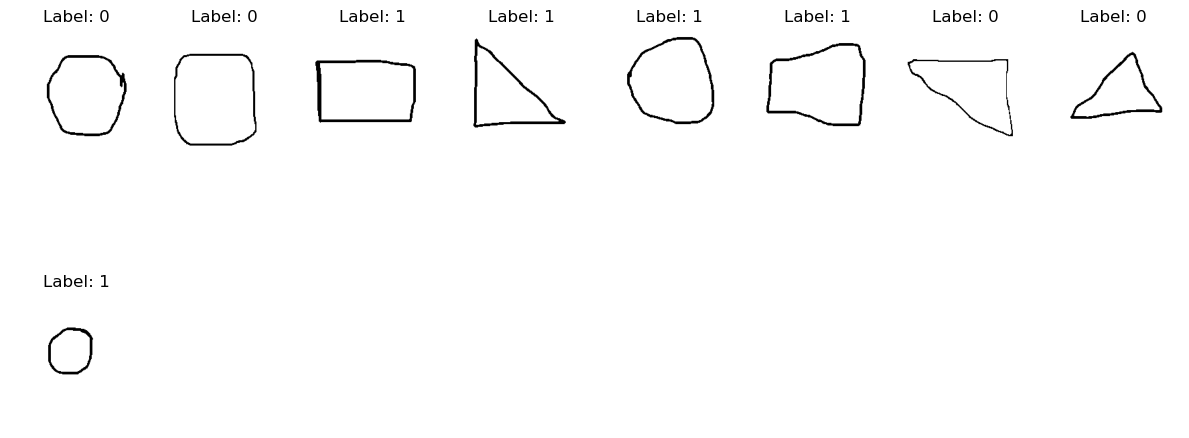

In [21]:
plot_dataset(x_val_p, y_pred, num_cols=8, cmap='gray')

## 3) Feature Extraction (Again)

##### Now let's do some feature engineering to extract better features

- Suppose we can get the area of the shape itself

- Suppose we can draw around it the minimum enclosing circle, triangle, reactangle and compute it's area

We can use the following feature for each shape:

$$ Z = (Z_0, Z_1, Z_2)= (\frac{ShapeArea(X)}{MinRectangleArea(X)}, \frac{ShapeArea(X)}{MinCircleArea(X)}, \frac{ShapeArea(X)}{MinTriangleArea(X)})$$
<br><br>
These three features are highly distinctive and should help our model learn the relation between `X` and `y` better as for circles, $Z_0$ will often be close to one, for triangles $Z_1$ will often be close to one and for rectangles, $Z_2$ will often be close to one.

In [22]:
def findOuterContourArea(img):    
    # This function finds the contours of a given image (img) and returns it in the variable contours
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    outer_contour = contours[1]             # an array of boundary pixels forming the outer boundary
    area = cv2.contourArea(outer_contour)   # the area enclosed by the outer boundary  
    return area, outer_contour

In [23]:
def extract_feature(img):
    area, outer_contour = findOuterContourArea(img)
    # minimum enclosing rectangle
    x, y, h, w = cv2.boundingRect(outer_contour)
    rect_area = w * h
    # minimum enclosing circle
    (x,y), radius = cv2.minEnclosingCircle(outer_contour)
    circle_area = np.pi * (radius**2)
    # minimum enclosing triangle
    triangle_area, _ = cv2.minEnclosingTriangle(outer_contour)
    return np.array([area/rect_area, area/circle_area, area/triangle_area])

x_train_pf = np.array([extract_feature(img) for img in x_train_p])
x_val_pf = np.array([extract_feature(img) for img in x_val_p])
print("shape of x_train:", x_train_pf.shape)
print("shape of x_val:", x_val_pf.shape)

shape of x_train: (20, 3)
shape of x_val: (9, 3)


### 3.1) Visualize Features

An elegant way to evaluate your features is to visualize them in 2D or 3D. In our case, we can visualize in 3D without any dimensionality reduction needed.

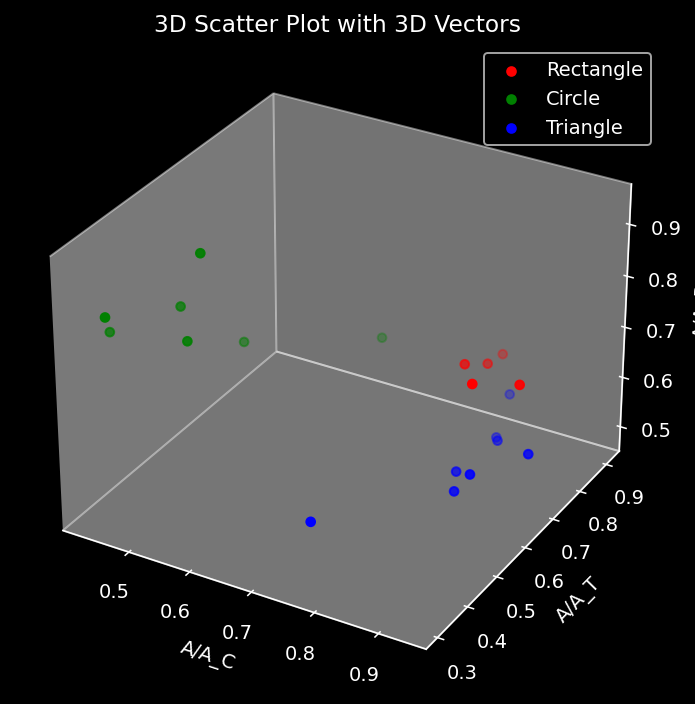

In [24]:
import matplotlib.pyplot as plt

# Mapping colors to each class
colors = ['r', 'g', 'b']
class_labels = ['Rectangle', 'Circle', 'Triangle']

# Creating scatter plot
plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 6), dpi=140)
ax = fig.add_subplot(111, projection='3d')

for i in range(3):  
    ax.scatter(x_train_pf[y_train == i, 0],
               x_train_pf[y_train == i, 1],
               x_train_pf[y_train == i, 2],
               c=colors[i], 
               label=class_labels[i]
               )

ax.set_title('3D Scatter Plot with 3D Vectors')
ax.set_xlabel('A/A_C')
ax.set_ylabel('A/A_T')
ax.set_zlabel('A/A_R')
ax.legend()

# Remove grid
ax.grid(False)
# ax.xaxis.pane.set_facecolor('black') to change plane color
plt.show()

## 4) Model Selection (Again)

Let's start by trying [NearestCentroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html)

In [25]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

# initiate and train the model
mdc = NearestCentroid(metric='euclidean')
mdc.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = mdc.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with NearestCentroid")

Accuracy: 0.8889 with NearestCentroid


No big improvement over random guessing. Let's try [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# initiate and train the model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean') 
knn.fit(x_train_pf, y_train)

# predict on the validation set
y_pred = knn.predict(x_val_pf)

# calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy, 4), "with KNeighborsClassifier")

Accuracy: 1.0 with KNeighborsClassifier


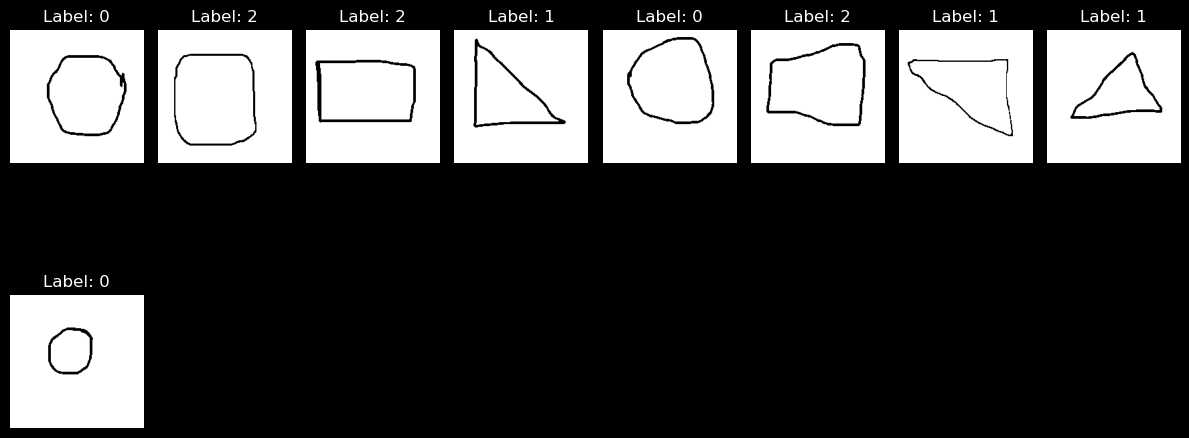

In [27]:
plot_dataset(x_val_p, y_pred, num_cols=8, cmap='gray')

## 5) Save and Deploy

Let's go for the minimum distance classifier because it's more efficient.

In [28]:
from joblib import dump, load
# save locally
dump(mdc, 'mdc.joblib') 

['mdc.joblib']

Load and run

In [29]:
mdc = load('mdc.joblib')
mdc.predict(x_val_pf)

array([0, 0, 2, 1, 0, 2, 1, 1, 0])

Check more classification and regression models [here](https://scikit-learn.org/stable/supervised_learning.html)